# Location modeling for microbiome colonization

## Recapitulate:
http://www.pnas.org/content/early/2017/10/04/1711596114.short
- macro-scale patterns:
    - [Fig 2A,B](http://www.pnas.org/content/pnas/early/2017/10/04/1711596114/F4.large.jpg)
- microhabitats composition (dominant):
    - dominant species: Bacteroides dominate all microhabitats
        - Bacteroides: 43% of densely colonized and 46% of sparsely colonized fields
        - C. aerofaciens: 11% in densely, 6% in sparsely
        - C. scindens: 8% in both
        - R. torques: 3% in dense, 2% in sparse    
- inter-taxa correlations ([Fig. S3](http://www.pnas.org/content/pnas/early/2017/10/04/1711596114/F9.large.jpg))
    - some species show negative correlation
    - but R^2 small and p-values not reported!
- micro-scale spatial patterns (numbers are for mouse)
    - proximal colon shows homogenized community due to mixing and dispersal by host factors
    - turnover for mucus is 6 h for mucus in goblet cells and 1 h for inner mucus layer in distal colon
    - replication time of B. thetaiotaomicron and E. coli is 3 h in mucus layer and 3-8 h in colonic contents
    - therefore, microbes divide only a few rounds before being shed along with mucus into lumen
    - gut contents traverse mouse intestine in 4-6 h
    - overall, the turnover and shedding diminishes/disrupts segregated communities and spatial structure
    - note: human dental plaque form clustered and ordered arrangements

### Bacteria:
http://www.pnas.org/content/early/2017/10/04/1711596114.short
- 6 species (in [AGORA](https://vmh.uni.lu/#downloadview)?):
    - Bacteroides cellulosilyticus (yes, DSM 14838)
    - Bacteroides caccae (yes, ATCC 43185)
    - Parabacteroides distasonis (yes, ATCC 8503)
    - Ruminococcus torques (yes, ATCC 27756, L2-14)
    - Clostridium scindens (yes, ATCC 35704)
    - Collinsella aerofaciens (yes, ATCC 25986)
- 4 Moderately abundant Bacteroides:
    - Bacteroides thetaiotaomicron (yes, VPI-5482)
    - Bacteroides vulgatus (yes, ATCC 8482)
    - Bacteroides ovatus (yes, ATCC 8483, SD CC 2a, SD CMC 3f)
    - Bacteroides uniformis (yes, ATCC 8492)
- 5 low abundance Firmicutes
    - Eubacterium rectale (yes, ATCC 33656, M104/1)
    - Clostridium spiroforme (yes, DSM 1552)
    - Faecalibacterium prausnitzii ()yes, L2-6
    - Ruminococcus obeum (yes, A2-162)
    - Dorea longicatena (yes, DSM 13814)

## Grid

In [1]:
from gurobipy import *

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['svg.fonttype'] = 'none'
pd.set_option('display.max_colwidth', -1)
%matplotlib inline

from cobra.io import load_json_model
from six import iteritems
import numpy as np
import cobra

In [49]:
from cobra.io.sbml3 import read_sbml_model

def repair_model(mdl):
    obj0 = mdl.optimize().f
    for rxn in mdl.reactions:
        rxn.id = rxn.id.replace('__40__','_').replace('__41__','')
    for met in mdl.metabolites:
        met.id = met.id.replace('__91__','_').replace('__93__','')
    mdl.repair()
    obj1 = mdl.optimize().f
    print('mu: before=%s. after=%s' % (obj0,obj1))
    assert abs(obj1-obj0)<1e-9

B_caccae = read_sbml_model('/home/laurence/ME/data/microbiome/Agora_1_02_Western/sbml/Bacteroides_caccae_ATCC_43185.xml')
repair_model(B_caccae)
B_cell = read_sbml_model('/home/laurence/ME/data/microbiome/Agora_1_02_Western/sbml/Bacteroides_cellulosilyticus_DSM_14838.xml')
repair_model(B_cell)
R_torques = read_sbml_model('/home/laurence/ME/data/microbiome/Agora_1_02_Western/sbml/Ruminococcus_torques_ATCC_27756.xml')
repair_model(R_torques)
C_spiro = read_sbml_model('/home/laurence/ME/data/microbiome/Agora_1_02_Western/sbml/Clostridium_spiroforme_DSM_1552.xml')
repair_model(C_spiro)

mu: before=0.527200385031. after=0.527200385031
mu: before=0.337029885021. after=0.337029885021
mu: before=0.1048777824. after=0.1048777824
mu: before=0.121469370222. after=0.121469370222


In [50]:
models = [B_caccae, R_torques, C_spiro]

In [51]:
for mdl in models:
    for rxn in mdl.reactions:
        if rxn.objective_coefficient != 0:
            print('mdl=%s. rxn=%s. objcoeff=%s' % (mdl.id, rxn.id, rxn.objective_coefficient))

mdl=Bacteroides_caccae_ATCC_43185. rxn=biomass536. objcoeff=1.0
mdl=Ruminococcus_torques_ATCC_27756. rxn=biomass525. objcoeff=1.0
mdl=Clostridium_spiroforme_DSM_1552. rxn=biomass525. objcoeff=1.0


In [5]:
from cobra.flux_analysis import flux_variability_analysis
from six import iteritems

def exchanged_mets(mdl, cons_thresh=-0.1, secr_thresh=0.1, f_opt=1., reqd_thresh=-1e-8,
                  exclude=['biomass_c','h2o_e','pi_e','ppi_e','h_e','k_e']):
    ex_rxn_all = mdl.reactions.query('^EX_')
    ex_rxn = [rxn for rxn in ex_rxn_all if not any([m in [met.id for met in rxn.metabolites.keys()] for m in exclude]) ]
    
    rxn_met_dict = {rxn.id:[m for m,s in iteritems(rxn.metabolites) if s<0] for rxn in ex_rxn}
    met_rxn_dict = {m.id:rxn.id for rxn in ex_rxn for m,s in iteritems(rxn.metabolites) if s<0}
    
    sol = flux_variability_analysis(mdl, ex_rxn, solver='gurobi', fraction_of_optimum=f_opt)
    secr = [m.id for k,v in iteritems(sol) if v['maximum']>=secr_thresh for m in rxn_met_dict[k]]
    cons = [m.id for k,v in iteritems(sol) if v['minimum']<=cons_thresh for m in rxn_met_dict[k]]
    reqd = [m.id for k,v in iteritems(sol) if v['maximum']<=reqd_thresh for m in rxn_met_dict[k]]
    req_rxns = [k for k,v in iteritems(sol) if v['maximum']<=reqd_thresh]
    return {'secreted':secr, 'consumed':cons, 'required':reqd, 'met_rxn':met_rxn_dict, 'req_rxns':req_rxns}

In [6]:
### Required mets
for mdl in models:
    res = exchanged_mets(mdl, f_opt=0.1)
    req = res['required']

In [7]:
req

['cobalt2_e',
 'so4_e',
 'cu2_e',
 'ca2_e',
 'zn2_e',
 'ala_L_e',
 'mg2_e',
 'fe3_e',
 'pydx_e',
 'met_L_e',
 'cl_e',
 'fe2_e',
 'mn2_e']

# Data frames

### Sources

In [8]:
rows = []
# Cross-feed sources
for mdl in models:
    exmets = exchanged_mets(mdl)
    mr_dict= exmets['met_rxn']
    secr = exmets['secreted']
    reqd = exmets['required']
    for met in secr:
        rxn = mr_dict[met]
        rows.append({'met':met, 'source':mdl.id, 'rxn':rxn, 'node':np.nan, 'vmax':np.nan})
        
# Primary sources
# each source should provide all mets to be constrained
ex1 = exchanged_mets(R_torques)
for met in ex1['consumed']:
    rows.append({'met':met, 'source':'primary', 'rxn':np.nan, 'node':3, 'vmax':1})

df_source = pd.DataFrame(rows)
df_source.head(2)

,met,node,rxn,source,vmax
0,ppa_e,NaN,EX_ppa_e,Bacteroides_caccae_ATCC_43185,NaN
1,for_e,NaN,EX_for_e,Bacteroides_caccae_ATCC_43185,NaN


### Consumers

In [9]:
rows = []
for mdl in models:
    exmets = exchanged_mets(mdl)
    mr_dict= exmets['met_rxn']
    cons = exmets['consumed']
    for met in cons:
        rxn = mr_dict[met]
        rows.append({'met':met, 'id':mdl.id, 'rxn':rxn})

df_consumer = pd.DataFrame(rows)
df_consumer.head(2)

,id,met,rxn
0,Bacteroides_caccae_ATCC_43185,leu_L_e,EX_leu_L_e
1,Bacteroides_caccae_ATCC_43185,fuc_L_e,EX_fuc_L_e


## Keep only the mets that are shared across producers and consumers
### Only keep primary sources that feed one microbe to force cross-feeding

In [10]:
r_cons = df_consumer.met[ df_consumer.id=='Ruminococcus_torques_ATCC_27756']
b_cons = df_consumer.met[ df_consumer.id=='Bacteroides_caccae_ATCC_43185']
mets_r = [r for r in r_cons if r not in b_cons.values]
mets_r

['glyc_e', 'glu_L_e', 'gly_e', 'gln_L_e', 'asp_L_e']

In [11]:
df_primary_lim = df_source[
    (df_source['source']=='primary') &
    (df_source.met.isin(mets_r))
]
df_cross =  df_source[ df_source['source'] != 'primary']
df_source_lim = pd.concat([df_primary_lim, df_cross])

In [12]:
shared_mets = np.intersect1d(df_source.met, df_consumer.met)
shared_mets

array(['arab_L_e', 'asp_L_e', 'fru_e', 'gal_e', 'glc_D_e', 'gln_L_e',
       'glu_L_e', 'gly_e', 'glyc_e', 'man_e', 'pro_L_e', 'ser_L_e',
       'thr_L_e', 'xyl_D_e'], dtype=object)

In [13]:
df_consumer_shared = df_consumer[ df_consumer.met.isin(shared_mets)]
df_source_shared = df_source[ df_source.met.isin(shared_mets)]

### Unless required or provided by a source (including cross-feed), disable uptake

In [14]:
src_mets = set(df_source['met'].values)
for mdl in models:
    res = exchanged_mets(mdl, f_opt=0.5)    
    mr_dict = res['met_rxn']
    src_rxns = [mr_dict[m] for m in src_mets if m in mr_dict]
    req_rxns = res['req_rxns']
    #dfi = df_consumer_shared[ df_consumer_shared['id']==mdl.id]
    dfi = df_consumer[ df_consumer['id']==mdl.id]
    cons_rxns = dfi.rxn.values
    ### Need to have full set for at least one sol
    mdl.optimize()
    opt_rxns = [r.id for r in mdl.reactions.query('EX_') if r.x < -1e-6]
    
    for rxn in mdl.reactions.query('^EX_'):
        #if rxn.id not in req_rxns and rxn.id not in src_rxns:            
        if rxn.id not in req_rxns and rxn.id not in cons_rxns and rxn.id not in opt_rxns:
            rxn.lower_bound = 0.
            #print("%s. Set lb=0 for %s" % (mdl.id, rxn.id))
    # Ensure model can still grow
    mdl.optimize()
    if mdl.solution is None:
        print("%s cannot grow anymore!" % mdl.id)
    else:
        print("%s can still grow at %s" % (mdl.id, mdl.solution.f))

Bacteroides_caccae_ATCC_43185 can still grow at 0.52720038503
Ruminococcus_torques_ATCC_27756 can still grow at 0.104877782401


### Nodes

In [15]:
data = {'x':[0,1,2, 0,1,2, 0,1,2, 0,1,2],
        'y':[0,0,0, 1,1,1, 2,2,2, 3,3,3],
        'node':[0,1,2, 3,4,5, 6,7,8, 9,10,11],
        'type':['org','org','org', 'source','org','org', 'org','org','org', 'org','org','org'],
        'Tf':[2,2,2, 2,2,2, 2,2,2, 2,2,2]
}
df_node = pd.DataFrame.from_dict(data)
df_node.index = df_node.node
df_node.head(2)

,Tf,node,type,x,y
node,,,,,
0,2,0,org,0,0
1,2,1,org,1,0


### Distances

In [16]:
rows = []
nodes = df_node.node.unique()
for i,rowi in df_node.iterrows():
    xi = rowi['x']
    yi = rowi['y']
    for j,rowj in df_node.iterrows():        
        xj = rowj['x']
        yj = rowj['y']
        dx = xj-xi
        dy = yj-yi
        d = np.sqrt(dx**2 + dy**2)
        rows.append({'i':i, 'j':j, 'd':d})

df_distance = pd.DataFrame(rows)
df_distance.head(2)

,d,i,j
0,0.0,0,0
1,1.0,0,1


### Organisms

In [52]:
rows = []
for mdl in models:
    for rxn in mdl.reactions:
        if rxn.objective_coefficient != 0:
            rows.append({'X0':1., 'biomass':rxn.id, 'id':mdl.id})
            print('mdl=%s. rxn=%s. objcoeff=%s' % (mdl.id, rxn.id, rxn.objective_coefficient))
df_organism = pd.DataFrame(rows)
df_organism

mdl=Bacteroides_caccae_ATCC_43185. rxn=biomass536. objcoeff=1.0
mdl=Ruminococcus_torques_ATCC_27756. rxn=biomass525. objcoeff=1.0
mdl=Clostridium_spiroforme_DSM_1552. rxn=biomass525. objcoeff=1.0


,X0,biomass,id
0,1.0,biomass536,Bacteroides_caccae_ATCC_43185
1,1.0,biomass525,Ruminococcus_torques_ATCC_27756
2,1.0,biomass525,Clostridium_spiroforme_DSM_1552


# Solve

In [53]:
from dynamicme.location import Locater

locater = Locater()
#locater.create_problem(models, df_source_lim, df_consumer_shared, df_node, df_distance, df_organism)
locater.create_problem(models, df_source, df_consumer, df_node, df_distance, df_organism)

In [54]:
from cobra.solvers import gurobi_solver

model = gurobi_solver.create_problem(locater.model)
model.Params.OutputFlag = 1
model.ModelSense == GRB.MAXIMIZE

Changed value of parameter OutputFlag to 1
   Prev: 0  Min: 0  Max: 1  Default: 1


True

In [55]:
model.optimize()

Optimize a model with 101447 rows, 34936 columns and 264836 nonzeros
Variable types: 34903 continuous, 33 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e-05, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e-05, 1e+03]
  RHS range        [1e+00, 1e+00]
Presolve removed 85756 rows and 26301 columns
Presolve time: 0.36s
Presolved: 15691 rows, 8635 columns, 62832 nonzeros
Variable types: 8602 continuous, 33 integer (33 binary)

Root relaxation: objective 3.852779e-01, 14731 iterations, 1.29 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.38528    0    8          -    0.38528      -     -    1s
H    0     0                       0.1214694    0.38528   217%     -    2s
     0     0    0.38528    0   10    0.12147    0.38528   217%     -    2s
     0     0    0.38528    0    9    0.12147    0.38528   217%     -    2s
H    0     0   

In [56]:
sol = gurobi_solver.format_solution(model, locater.model)

In [57]:
locater.model.solution = sol

In [58]:
for rxn in locater.model.reactions.query('^y_'):
    x = sol.x_dict[rxn.id]
    print("%-20.18s%-20s" % (x, rxn.id))

-0.0                y_Ruminococcus_torques_ATCC_27756_2
1.0                 y_Ruminococcus_torques_ATCC_27756_0
-0.0                y_Ruminococcus_torques_ATCC_27756_1
-0.0                y_Ruminococcus_torques_ATCC_27756_6
-0.0                y_Ruminococcus_torques_ATCC_27756_7
0.0                 y_Ruminococcus_torques_ATCC_27756_4
-0.0                y_Ruminococcus_torques_ATCC_27756_5
-0.0                y_Ruminococcus_torques_ATCC_27756_8
-0.0                y_Ruminococcus_torques_ATCC_27756_9
-0.0                y_Clostridium_spiroforme_DSM_1552_9
1.0                 y_Clostridium_spiroforme_DSM_1552_8
-0.0                y_Clostridium_spiroforme_DSM_1552_1
-0.0                y_Clostridium_spiroforme_DSM_1552_0
-0.0                y_Clostridium_spiroforme_DSM_1552_2
-0.0                y_Clostridium_spiroforme_DSM_1552_5
-0.0                y_Clostridium_spiroforme_DSM_1552_4
-0.0                y_Clostridium_spiroforme_DSM_1552_7
-0.0                y_Clostridium_spiroforme_DSM

In [59]:
x_dict = locater.model.solution.x_dict

for cons in locater.model.metabolites.query('uptake_cap'):
    print('-'*60)
    print(cons.id)
    for rxn in cons.reactions:
        x = x_dict[rxn.id]
        print("%s\t%s\t%s" % (rxn.id, rxn.metabolites[cons], x))

------------------------------------------------------------
uptake_cap_Bacteroides_caccae_ATCC_43185_0_leu_L_e
EX_leu_L_e_Bacteroides_caccae_ATCC_43185_0	-1.0	-4.54747350886e-13
------------------------------------------------------------
uptake_cap_Bacteroides_caccae_ATCC_43185_1_leu_L_e
EX_leu_L_e_Bacteroides_caccae_ATCC_43185_1	-1.0	-4.54747350886e-13
------------------------------------------------------------
uptake_cap_Bacteroides_caccae_ATCC_43185_2_leu_L_e
EX_leu_L_e_Bacteroides_caccae_ATCC_43185_2	-1.0	-4.54747350886e-13
------------------------------------------------------------
uptake_cap_Bacteroides_caccae_ATCC_43185_4_leu_L_e
EX_leu_L_e_Bacteroides_caccae_ATCC_43185_4	-1.0	-4.54747350886e-13
------------------------------------------------------------
uptake_cap_Bacteroides_caccae_ATCC_43185_5_leu_L_e
EX_leu_L_e_Bacteroides_caccae_ATCC_43185_5	-1.0	-4.54747350886e-13
------------------------------------------------------------
uptake_cap_Bacteroides_caccae_ATCC_43185_6_l

In [60]:
x_dict = locater.model.solution.x_dict

for cons in locater.model.metabolites.query('source_cap'):
    print('-'*60)
    print(cons.id)
    for rxn in cons.reactions:
        x = x_dict[rxn.id]
        print("%s\t%s\t%s" % (rxn.id, rxn.metabolites[cons], x))

------------------------------------------------------------
source_capacity_3_thr_L_e
s_3_5_thr_L_e	1.0	1.38777878078e-17
s_3_1_thr_L_e	1.0	0.0
s_3_7_thr_L_e	1.0	2.78457812364e-13
s_3_0_thr_L_e	1.0	0.225000000001
s_3_6_thr_L_e	1.0	0.549999999997
s_3_4_thr_L_e	1.0	0.225000000001
s_3_11_thr_L_e	1.0	0.0
s_3_8_thr_L_e	1.0	0.0
s_3_2_thr_L_e	1.0	1.38777878078e-17
s_3_10_thr_L_e	1.0	2.77555756156e-17
s_3_9_thr_L_e	1.0	0.0
------------------------------------------------------------
source_capacity_3_ser_L_e
s_3_0_ser_L_e	1.0	2.8844366895e-09
s_3_2_ser_L_e	1.0	0.0
s_3_10_ser_L_e	1.0	1.66153694511e-11
s_3_8_ser_L_e	1.0	-5.41958304042e-11
s_3_9_ser_L_e	1.0	2.64413001117e-11
s_3_6_ser_L_e	1.0	0.0
s_3_5_ser_L_e	1.0	2.76335192348e-11
s_3_1_ser_L_e	1.0	-7.58225468254e-10
s_3_4_ser_L_e	1.0	1.0
s_3_7_ser_L_e	1.0	-1.23361448296e-09
s_3_11_ser_L_e	1.0	0.0
------------------------------------------------------------
source_capacity_3_man_e
s_3_7_man_e	1.0	0.0
s_3_6_man_e	1.0	0.0
s_3_0_man_e	1.0	0.148986

In [61]:
x_dict = locater.model.solution.x_dict

cons=locater.model.metabolites.query('crossfeed_')[0]
for rxn in cons.reactions:
    x = x_dict[rxn.id]
    print("%s\t%s\t%s" % (rxn.id, rxn.metabolites[cons], x))

EX_ppa_e_Bacteroides_caccae_ATCC_43185_0	-1.0	1.34097372396e-09
EX_ppa_e_Ruminococcus_torques_ATCC_27756_0	-1.0	0.205438247489


## Check to see what each org,node is growing on

locater.model.reactions.query('^biomass')

locater.model.reactions.query('^y_')

cons = locater.model.metabolites.query('cons_uptake')[0]
cons.reactions

locater.model.metabolites.query('cons_uptake')

df_ex

df_sources.head()

# Plot the result

### Source lines

In [69]:
ZERO = 1e-8
x_dict = locater.model.solution.x_dict
org_ids= [mdl.id for mdl in models]
nodes  = df_node.node.unique()
mets   = df_source.met.unique()

rows = []
line_rows = []
for ni,nrow in df_node.iterrows():
    x = nrow['x']
    y = nrow['y']
    node = nrow['node']
    typ = nrow['type']
    if typ=='source':
        density = df_source[ df_source['node']==node].vmax.iloc[0]
        rows.append({'x':x, 'y':y, 'density':density, 'type':typ})
        # rows.append({'x':x, 'y':y, 'density':0, 'type':typ})
    else:
        for oi,orow in df_organism.iterrows():
            mu_id = orow['biomass']
            org_id = orow['id']
            yid = 'y_%s_%s'%(org_id,node)
            yval = x_dict[yid]
            if yval > 0.5:
                mu_id = '%s_%s_%s'%(mu_id,org_id,node)
                mu = x_dict[mu_id]
            else:
                mu = 0.
            rows.append({'x':x,'y':y,'density':mu, 'type':org_id})
    ### Source lines
    for locp in nodes:
        xp = df_node.loc[locp]['x']
        yp = df_node.loc[locp]['y']
        for met in mets:
            sid = 's_%s_%s_%s'%(locp,node,met)            
            if x_dict.has_key(sid):
                spjl = x_dict[sid]
                if spjl>ZERO:
                    line_rows.append({'xj':x,'yj':y, 'xp':xp,'yp':yp, 's':spjl,'p':locp,'j':node,
                                     'type':'source', 'met':met})
            eid = 'e_%s_%s_%s'%(locp,node,met)
            if x_dict.has_key(eid):
                eijl = x_dict[eid]
                if eijl>ZERO:
                    line_rows.append({'xj':x,'yj':y, 'xp':xp,'yp':yp, 's':eijl,'p':locp,'j':node,
                                     'type':'cross', 'met':met})
dsplot = pd.DataFrame(rows)

In [70]:
dsplot = dsplot.groupby(['x','y']).agg({'density':lambda x: max(x)}).reset_index()

In [71]:
### Greater contrast for visualization
dsplot.loc[:,'z'] = dsplot.density
dsplot.loc[ dsplot.z==0,'z'] = -1

In [72]:
df_line = pd.DataFrame(line_rows)

# Plot results

plot_dict = {
    'x':[0,2,0, 1,2,1, 0,1,2],
    'y':[1,1,0, 0,0,1, 2,2,2],
    'type':['cellb','acgal','org', 'org','org','org', 'org','org','org'],
    'density':[2,2,1, 1,1,1, 1,1,1]
}
dsplot = pd.DataFrame.from_dict(plot_dict)

from dynamicme.location import CommunityPlotter
plotter = CommunityPlotter()
plotter.plot(dsplot, zcol='density', points=True)

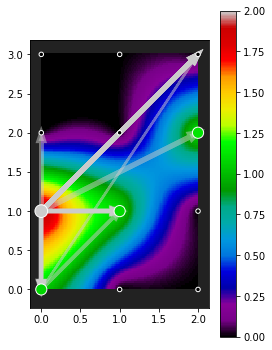

In [75]:
import matplotlib
from scipy import interpolate

nres = 121
x = dsplot.x
y = dsplot.y
#z = dsplot.density
z = dsplot.z - dsplot.z.min()
xx = np.linspace(x.min(), x.max(), nres)
yy = np.linspace(y.min(), y.max(), nres)
X,Y = np.meshgrid(xx,yy)

### Add some noise to prevent singular matrix in interpolate
dr = 0 #0.001
xr = x + np.random.uniform(-dr, dr, size=x.shape)
yr = y + np.random.uniform(-dr, dr, size=y.shape)
#rbf = interpolate.Rbf(xr,yr,z, function='gaussian')
rbf = interpolate.Rbf(xr,yr,z, function='linear')
#rbf = interpolate.Rbf(x,y,z, function='cubic')
#rbf = interpolate.RectBivariateSpline(x,y,z)
Z = rbf(X,Y)

ax = plt.imshow(Z, vmin=z.min(), vmax=z.max(), origin='lower',
          extent=[x.min(), x.max(), y.min(), y.max()])

#cmap = 'nipy_spectral'
cmap = matplotlib.cm.get_cmap('nipy_spectral')
#cmap.set_under()
ax.set_cmap(cmap)

ax = plt.scatter(x, y, c=z, edgecolors='#ffffff', s=20+np.sqrt(z*10000), zorder=4)
ax.set_cmap(cmap)

### Plot the lines
for i,row in df_line.iterrows():
    xp = row['xp']
    yp = row['yp']
    xj = row['xj']
    yj = row['yj']
    s  = row['s']
    #ax.axes.plot(x=[xp,xj], y=[yp,yj], color='#ffffff', lw=10*s)
    #plt.plot([xp,xj], [yp,yj], color='#aaaaaa', lw=(50*s)**0.5, ls='-', alpha=0.5)    
    dx = xj-xp
    dy = yj-yp
    w = 2+(10*s)**0.5
    plt.arrow(xp, yp, dx, dy, color='#cccccc', lw=w, ls='-', head_width=0.07,
              alpha=0.5, length_includes_head=True)

ax.axes.set_facecolor('#222222')
plt.colorbar()
ax.figure.set_size_inches(4,6)

### Debug zone

In [89]:
for rxn in locater.model.reactions.query('^y.*_11'):
    x = x_dict[rxn.id]
    print('%-20.18s%s'%(x, rxn.id))

-0.0                y_Clostridium_spiroforme_DSM_1552_11
-0.0                y_Ruminococcus_torques_ATCC_27756_11
-0.0                y_Bacteroides_caccae_ATCC_43185_11


In [88]:
for rxn in locater.model.reactions.query('^s.*_11'):
    x = x_dict[rxn.id]
    print('%-20.18s%s'%(x, rxn.id))

0.0                 sink_s_Bacteroides_caccae_ATCC_43185_11
-0.0                sink_dmbzid_Ruminococcus_torques_ATCC_27756_11
0.0                 s_3_11_thr_L_e
0.0                 s_3_11_ser_L_e
0.702027999992      s_3_11_man_e
0.642433999995      s_3_11_xyl_D_e
0.642434000041      s_3_11_arab_L_e
0.702027999974      s_3_11_glc_D_e
0.702027999986      s_3_11_gal_e
0.702027999984      s_3_11_fru_e
0.0                 s_3_11_glyc_e
0.819999999999      s_3_11_glu_L_e
4.26297191991e-12   s_3_11_gly_e
0.819999999999      s_3_11_gln_L_e
0.774999999998      s_3_11_asp_L_e


In [87]:
for rxn in locater.model.reactions.query('^e.*_11'):
    x = x_dict[rxn.id]
    print('%-20.18s%s'%(x, rxn.id))

0.0                 e_11_0_pro_L_e
0.0                 e_11_1_pro_L_e
0.0                 e_11_2_pro_L_e
0.0                 e_11_4_pro_L_e
0.0                 e_11_5_pro_L_e
0.0                 e_11_6_pro_L_e
0.0                 e_11_7_pro_L_e
0.0                 e_11_8_pro_L_e
0.0                 e_11_9_pro_L_e
0.0                 e_11_10_pro_L_e
0.0175507988571     e_0_11_pro_L_e
0.0                 e_1_11_pro_L_e
0.0                 e_2_11_pro_L_e
0.0                 e_4_11_pro_L_e
0.0                 e_5_11_pro_L_e
0.0                 e_6_11_pro_L_e
1.11322548402e-11   e_7_11_pro_L_e
2.00474038487e-11   e_8_11_pro_L_e
0.0                 e_9_11_pro_L_e
0.0                 e_10_11_pro_L_e


In [90]:
for rxn in locater.model.reactions.query('^e_0_.*'):
    x = x_dict[rxn.id]
    print('%-20.18s%s'%(x, rxn.id))

1.88710676715e-10   e_0_1_pro_L_e
0.0                 e_0_2_pro_L_e
0.254558441228      e_0_4_pro_L_e
0.0                 e_0_5_pro_L_e
0.0                 e_0_6_pro_L_e
0.0                 e_0_7_pro_L_e
0.0                 e_0_8_pro_L_e
0.0                 e_0_9_pro_L_e
0.0                 e_0_10_pro_L_e
0.0175507988571     e_0_11_pro_L_e


In [91]:
for rxn in locater.model.reactions.query('^e_4_.*'):
    x = x_dict[rxn.id]
    print('%-20.18s%s'%(x, rxn.id))

0.0                 e_4_0_pro_L_e
0.0                 e_4_1_pro_L_e
0.0                 e_4_2_pro_L_e
0.0                 e_4_5_pro_L_e
0.0                 e_4_6_pro_L_e
0.0                 e_4_7_pro_L_e
0.0                 e_4_8_pro_L_e
0.0                 e_4_9_pro_L_e
0.0                 e_4_10_pro_L_e
0.0                 e_4_11_pro_L_e


In [92]:
for rxn in locater.model.reactions.query('^e_8_.*'):
    x = x_dict[rxn.id]
    print('%-20.18s%s'%(x, rxn.id))

0.0                 e_8_0_pro_L_e
0.0                 e_8_1_pro_L_e
0.0                 e_8_2_pro_L_e
0.0                 e_8_4_pro_L_e
0.0                 e_8_5_pro_L_e
0.0                 e_8_6_pro_L_e
0.0                 e_8_7_pro_L_e
0.0                 e_8_9_pro_L_e
0.0                 e_8_10_pro_L_e
2.00474038487e-11   e_8_11_pro_L_e
